In [8]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re

In [9]:
# read file ktotal
df_ktotal = pd.read_csv("ktotal_contratos.csv")
# clean data
### format col names 
df_ktotal.columns = df_ktotal.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_ktotal = df_ktotal[['cct_ctl_id','cct_warranty_start_date', 'cct_contract_source', 'cct_plan_id', 
                       'cct_contract_status_id']]
df_ktotal = df_ktotal.rename(columns={'cct_ctl_id': 'stockid', 'cct_warranty_start_date':'date_delivery', 
                                      'cct_contract_source':'source', 'cct_plan_id':'payment'})
### only include trade-ins
df_ktotal_ti = df_ktotal[(df_ktotal['source']== 3) & (df_ktotal['payment']== 0)]
### format date col
df_ktotal_ti['date_delivery'] = pd.to_datetime(df_ktotal_ti['date_delivery'])
### keep only relevant cols
df_ktotal_ti = df_ktotal_ti[['stockid', 'date_delivery']]
# examine data
print(len(set(df_ktotal_ti['stockid'])))
print(df_ktotal_ti[df_ktotal_ti.duplicated('stockid')])
print(df_ktotal_ti.shape)
df_ktotal_ti.head()

624
      stockid date_delivery
752     26735    2020-11-30
835     21470    2020-10-22
870     18945    2020-12-01
892     23746    2020-11-02
1097    26594    2020-11-16
1361    21940    2020-10-27
1365    23705    2020-11-09
1535    16724    2020-10-20
1833    27690    2020-12-01
1860    24841    2020-10-30
2134    21125    2020-10-19
2142    27079    2020-11-27
2155    27585    2020-12-03
(637, 2)


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,stockid,date_delivery
21,22652,NaT
23,21906,2020-10-05
36,21697,2020-11-02
47,24142,NaT
70,23625,2020-11-02


In [10]:
# read file
df = pd.read_csv("kcapital_contratos.csv")
# clean data
### clean col names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### only include cars with kcapital
df =  df[df['financiamiento_ganado'] == 'Yes']
### select and rename relevant cols
df = df[['estimate', 'stock_id','dia_solicitud_aprobada', 'cotizar_kavak_total', 'autorizacion_del_cliente']]
df = df.rename(columns={'dia_solicitud_aprobada': 'date_approved', 'cotizar_kavak_total':'quote_ktot', 
                                 'autorizacion_del_cliente':'autorization_ktot', 'stock_id':'stockid'})
### format date col
df['date_approved'] = pd.to_datetime(df['date_approved'], dayfirst=True)
### sort and filter by stockid
df = df.sort_values('date_approved', ascending=False)
df = df.drop_duplicates('stockid')
# examine data
print(df.shape)
df.head(10)

(1310, 5)


,estimate,stockid,date_approved,quote_ktot,autorization_ktot
3226,3499523,25813,2020-12-07,No,No
3276,3530745,17047,2020-12-05,Yes,Yes
3272,3527324,28829,2020-12-05,Yes,Yes
3266,3519138,26830,2020-12-05,Yes,No
3181,3474460,27009,2020-12-05,No,No
2787,3316036,25080,2020-12-04,No,No
3120,3443083,27918,2020-12-04,No,No
2921,3372512,24702,2020-12-04,No,No
3184,3475035,25750,2020-12-04,No,No
3108,3437007,22711,2020-12-04,No,No


In [11]:
# Transform kcap to include trade-in col
tradein = np.zeros(len(df))
for i in range(len(df)):
    if int(df['stockid'].iloc[i]) in df_ktotal_ti['stockid'].values:
        tradein[i] = 1        
df['tradein'] = tradein
# find trade-ins financed by kcapital
df_kcap_ti = df[df['tradein'] == 1]
print(df_kcap_ti.shape)
df_kcap_ti.to_csv('kcap_tradeins.csv')
# remove kcap trade-in sales 
df = df[df['tradein'] != 1]
df.shape

(122, 6)


(1188, 6)

In [12]:
df[df['date_approved'].isnull()]

,estimate,stockid,date_approved,quote_ktot,autorization_ktot,tradein
354,2162433,18978,NaT,No,No,0.0
1571,2926026,24392,NaT,No,No,0.0
1980,3090087,25894,NaT,No,No,0.0
2368,3190697,15719,NaT,No,No,0.0


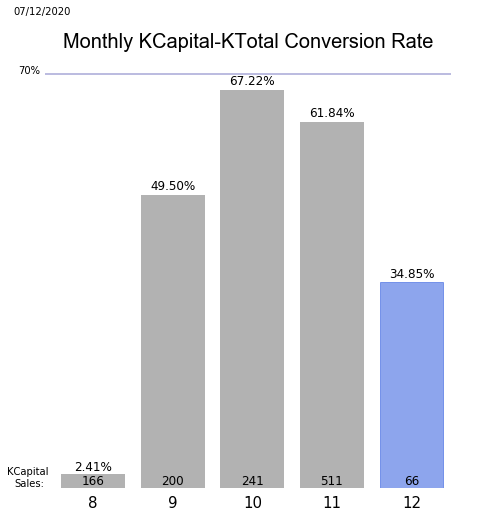

In [13]:
# Graph 1: MTD
### create month col
df['month'] = df['date_approved'].dt.month
### initialize dics
monthly_kcapital = {}
monthly_data = {}
### calculate monthly percentage
for month, frame in df.groupby(['month']):
    kcapital = len(frame)
    ktotal = 0
    for i in range(kcapital):
        if((frame['quote_ktot'].iloc[i] == 'Yes') & 
                   (frame['autorization_ktot'].iloc[i] == 'Yes')): ktotal += 1
    monthly_kcapital[month] = kcapital
    monthly_data[month] = float(ktotal)/float(kcapital)
### set x and y values
x_month = monthly_data.keys()
y_month = monthly_data.values()
### create figure and format axes
figure(figsize=(8,8))
bar1 = plt.bar(x_month, y_month, alpha=.6, color="gray")
plt.title('Monthly KCapital-KTotal Conversion Rate', 
          fontsize=20, fontname="Arial")
plt.xticks(x_month, fontsize=15)
plt.yticks([])
### label bars
plt.text(7.2, 0,"KCapital \nSales:", fontsize=10, ha='center', va='bottom', rotation=0)
def autolabel(rects):
    for idx,rect in enumerate(bar1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.008*height,
                "{:.2%}".format(y_month[idx]), fontsize=12,
                ha='center', va='bottom', rotation=0)
        plt.text(rect.get_x() + rect.get_width()/2., .0015,
                monthly_kcapital.values()[idx], fontsize=12,
                ha='center', va='bottom', rotation=0)
autolabel(bar1)
### add color to current bar
bar1[len(x_month)-1].set_color('royalblue')
### add hline and text at 70%
plt.hlines(.7, 7.4, 12.5, alpha=.35, color='darkblue')
plt.text(7.2, .7,"70%", fontsize=10, ha='center', rotation=0)
### remove spines and tick marks
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False)
### add timestamp
hoy = datetime.date(datetime.now())
plt.text(7, .8, hoy.strftime('%d/%m/%Y'), fontsize=10)
### save plot
plt.savefig('kcapital_cr.png')  

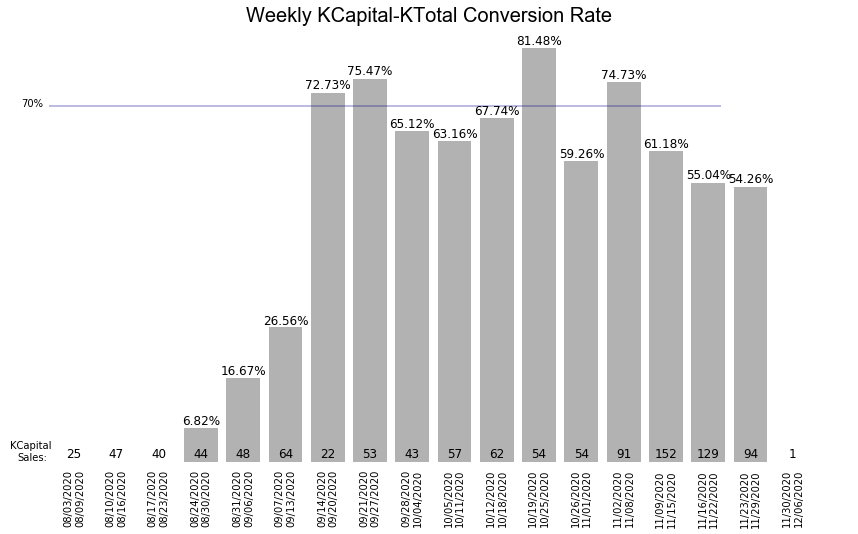

In [35]:
# Graph 2: Weekly report
### create week col
df['week'] = df['date_approved'].dt.week
### initialize dics
weekly_kcapital = {}
weekly_data = {}
weekly_dates = {}
### calculate weekly percentage
for group, frame in df.groupby(['week']):
    kcapital = len(frame)
    ktotal = 0
    for i in range(kcapital):
        if((frame['quote_ktot'].iloc[i] == 'Yes') & 
                   (frame['autorization_ktot'].iloc[i] == 'Yes')): ktotal += 1
    weekly_kcapital[group] = kcapital
    ##### extract dates of begining and end of week
    one_day = timedelta(days=1)
    sun_date = min(frame['date_approved']).date()
    while sun_date.weekday() != 0:
        sun_date = sun_date - one_day
    sat_date = max(frame['date_approved']).date()
    while sat_date.weekday() != 6:
        sat_date = sat_date + one_day
    weekly_dates[group] = ('\n'.join([sun_date.strftime('%m/%d/%Y'),sat_date.strftime('%m/%d/%Y')]))
    #####
    weekly_data[group] = float(ktotal)/float(kcapital)
### set x and y values
x_week = weekly_data.keys()
y_week = weekly_data.values()
### create figure and format axes
figure(figsize=(15,8))
bar2 = plt.bar(x_week, y_week, alpha=.6, color="gray")
plt.title('Weekly KCapital-KTotal Conversion Rate', 
          fontsize=20, fontname="Arial")
plt.xticks(weekly_dates.keys(), weekly_dates.values(), fontsize=10, rotation='vertical')
plt.yticks([])
### label bars
plt.text(31, 0,"KCapital \nSales:", fontsize=10, ha='center', va='bottom', rotation=0)
def autolabel(rects):
    for idx,rect in enumerate(bar2):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., .005,
            weekly_kcapital.values()[idx], fontsize=12,
            ha='center', va='bottom', rotation=0)
        if(round(y_week[idx], 2) == 0.00): 
            continue 
        else:
            plt.text(rect.get_x() + rect.get_width()/2., 1.003*height,
                "{:.2%}".format(y_week[idx]), fontsize=12,
                ha='center', va='bottom', rotation=0)
autolabel(bar2)
### add color to current bar
bar2[len(x_week)-1].set_color('royalblue')
### add hline and text at 70%
plt.hlines(.7, 31.4, 47.3, alpha=.35, color='darkblue')
plt.text(31, .7,"70%", fontsize=10, ha='center', rotation=0)
### remove spines and tick marks
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False)
#plt.savefig('weekly_update.png')  

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


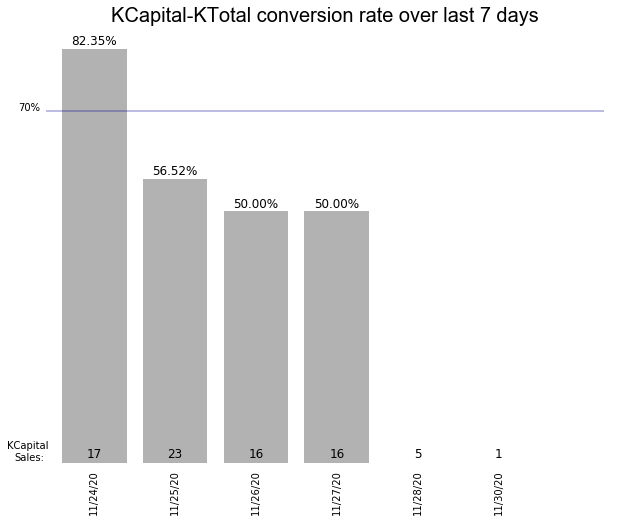

In [28]:
# Graph 3: Daily report
last_update = max(df['date_approved']).date()
week_ago = last_update - timedelta(days=6)
past_week_df = df[(df['date_approved'] >= pd.Timestamp(week_ago)) & 
                  (df['date_approved'] <= pd.Timestamp(last_update))]
### create day col
past_week_df['date'] = past_week_df['date_approved'].dt.strftime("%d")
### initialize dics
daily_kcapital = {}
daily_data = {}
daily_dates = {}
### calculate daily percentage
for group, frame in past_week_df.groupby(['date']):
    kcapital = len(frame)
    ktotal = 0
    for i in range(kcapital):
        if((frame['quote_ktot'].iloc[i] == 'Yes') & 
                   (frame['autorization_ktot'].iloc[i] == 'Yes')): ktotal += 1
    daily_kcapital[group] = kcapital
    daily_data[group] = float(ktotal)/float(kcapital)
    daily_dates[group] = min(frame['date_approved']).date().strftime('%m/%d/%y')
daily_kcapital = OrderedDict(sorted(daily_kcapital.items()))
daily_data = OrderedDict(sorted(daily_data.items()))
daily_dates = OrderedDict(sorted(daily_dates.items()))
### set x and y values
x_day = daily_data.keys()
y_day = daily_data.values()
### create figure and format axes
figure(figsize=(11,8))
bar3 = plt.bar(x_day, y_day, alpha=.6, color="gray")
plt.title('KCapital-KTotal conversion rate over last 7 days', 
          fontsize=20, fontname="Arial")
plt.xticks(daily_dates.keys(), daily_dates.values(), fontsize=10, rotation='vertical')
plt.yticks([])
### label bars
plt.text(-.8, 0,"KCapital \nSales:", fontsize=10, ha='center', va='bottom', rotation=0)
def autolabel(rects):
    for idx,rect in enumerate(bar3):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., .005,
            daily_kcapital.values()[idx], fontsize=12,
            ha='center', va='bottom', rotation=0)
        if(round(y_day[idx], 2) == 0.00): 
            continue 
        else:
            plt.text(rect.get_x() + rect.get_width()/2., 1.003*height,
                "{:.2%}".format(y_day[idx]), fontsize=12,
                ha='center', va='bottom', rotation=0)
autolabel(bar3)
### add color to current bar
bar3[len(x_day)-1].set_color('royalblue')
### add hline and text at 70%
plt.hlines(.7, -.6, 6.3, alpha=.35, color='darkblue')
plt.text(-.8, .7,"70%", fontsize=10, ha='center', rotation=0)
### remove spines and tick marks
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False)
#plt.savefig('daily_update.png')  
